In [3]:
from metaflow import Flow, Step, Run

def list_all_vars_in_step(
        flow, step, run=None):
    """
    Lists all Metaflow artifacts in a particular flow in a particular step.

    Parameters:
    flow (String): Name of flow
    step (String): Name of step
    run (String): Number of run. Omit if you want the latest

    Returns:
    List of all artifacts stored in the step
    """

    # Get the specified flow
    flow_obj = Flow(flow)
    
    # If run is not specified, get the latest run
    if run is None:
        run_obj = flow_obj.latest_run
    else:
        run_obj = Run(f'{flow}/{run}')
    
    # Get the specified step
    step_obj = run_obj[step]
    
    # List all artifacts in the step
    artifacts = [artifact.name for artifact in step_obj.artifacts]

    print(artifacts)
    

In [4]:
latest_run = Flow('main_flow').latest_run
step = latest_run['evaluate_model']
sample_image = step.task.data.image
sample_image = sample_image[0,:, :, :]
print(sample_image)
print(type(sample_image))
print(sample_image.shape)

tf.Tensor(
[[[114  37 139]
  [121  45 145]
  [130  54 154]
  ...
  [ 70  84 111]
  [ 70  85 114]
  [ 90 105 134]]

 [[127  52 147]
  [131  56 149]
  [134  59 150]
  ...
  [ 60  74 101]
  [ 64  79 108]
  [ 82  97 126]]

 [[139  64 146]
  [137  63 142]
  [133  59 134]
  ...
  [ 50  64  91]
  [ 60  75 104]
  [ 71  86 115]]

 ...

 [[211 137 188]
  [207 133 184]
  [202 128 179]
  ...
  [143  88 117]
  [152 101 132]
  [150 101 131]]

 [[206 129 183]
  [202 125 179]
  [198 121 175]
  ...
  [144  89 118]
  [151 100 131]
  [144  95 127]]

 [[199 120 177]
  [197 118 175]
  [193 116 170]
  ...
  [147  92 123]
  [153 102 133]
  [142  93 125]]], shape=(416, 416, 3), dtype=uint8)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(416, 416, 3)


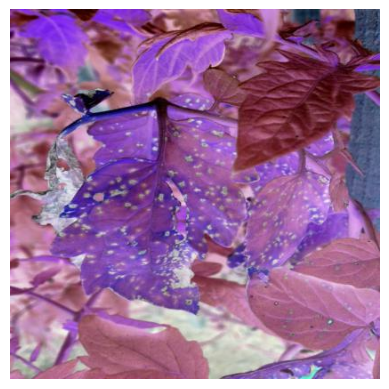

In [5]:
import matplotlib.pyplot as plt

one_image_normalized = sample_image / 255

# Display the image using matplotlib
plt.imshow(one_image_normalized)
plt.axis('off')  # Hide the axes
plt.show()

In [6]:
latest_run = Flow('main_flow').latest_run
step = latest_run['evaluate_model']
y_pred = step.task.data.y_pred
print(y_pred)

{'boxes': <tf.RaggedTensor [[]]>, 'confidence': <tf.RaggedTensor [[]]>, 'classes': <tf.RaggedTensor [[]]>, 'num_detections': array([0], dtype=int32)}


In [61]:
from utils import create_model
import tensorflow as tf
import keras_cv
from keras_cv import bounding_box

config = {
            "base_lr": 0.0001,
            "loss": "sparse_categorical_crossentropy",
            "epoch": 40,
            "batch_size": 32,
            "classification_loss": "focal",
            "box_loss": "smoothl1",
            "num_examples": 1,
            "bbox_format": "xyxy",
            "img_size": 416,
            "patience": 6
        }

model_dict = step.task.data.model
model_weights = model_dict['model_weights']

model = create_model(config=config)

# checkpoint_path = "best-custom-model.weights.h5"
# model.load_weights(checkpoint_path)

model.set_weights(model_weights)

model.prediction_decoder = keras_cv.layers.MultiClassNonMaxSuppression(
    bounding_box_format=config['bbox_format'],
    from_logits=True,
    iou_threshold=0.8,
    confidence_threshold=0.3,
)

image = tf.expand_dims(sample_image, axis=0)  # Shape: (1, 416, 416, 3)

y_pred = model.predict(image)
confidence = y_pred['confidence'][0]
confidence = [conf for conf in confidence if conf != -1]
print(f"confidence: {confidence}")

y_pred = bounding_box.to_ragged(y_pred)

boxes = y_pred['boxes']
classes = y_pred['classes']
print(boxes)
print(classes)

/Users/ed/miniconda3/envs/plant-object-detection/lib/python3.11/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/Users/ed/miniconda3/envs/plant-object-detection/lib/python3.11/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


1/1 [==============================] - 2s 2s/step
confidence: [0.3353153, 0.32636464, 0.3216686, 0.3162961, 0.3117943, 0.30799448, 0.30461973, 0.30345896, 0.30042776]
<tf.RaggedTensor [[[53.378242, 154.38072, 191.85278, 325.24542],
  [49.28424, 142.60287, 180.75867, 299.9382],
  [43.015724, 136.20506, 224.83026, 316.1855],
  [39.21295, 140.56892, 193.24281, 293.77582],
  [217.14182, 27.273758, 401.4714, 203.00185],
  [34.113655, 145.1767, 215.00415, 326.14154],
  [248.48193, 226.19366, 417.76337, 388.99573],
  [43.974586, 142.38527, 203.1034, 289.9223],
  [37.90132, 147.91748, 227.81087, 351.72864]]]>
<tf.RaggedTensor [[21.0, 21.0, 24.0, 29.0, 19.0, 18.0, 19.0, 13.0, 21.0]]>


In [35]:
flow = Flow('main_flow')
run = Run(flow['8'])
step = run['evaluate_model']
y_pred = step.task.data.y_pred
print(y_pred)

AttributeError: 'Run' object has no attribute 'split'